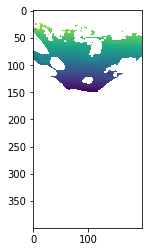

In [51]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pyransac3d 

RESOLUTION = 0.005
with open('map-20220122-155134.pkl', 'rb') as f:
    data = pickle.load(f)

data = np.array(data)
height_map = data[0]
plt.imshow(height_map)

plt.show()


In [2]:
height_map.shape

(400, 200)

In [52]:
xgrid, ygrid = np.meshgrid(np.linspace(0, height_map.shape[1]*RESOLUTION, height_map.shape[1]), np.linspace(0, height_map.shape[0]*RESOLUTION, height_map.shape[0]))
xyz = np.zeros((np.size(xgrid), 3))
xyz[:,0] = np.reshape(xgrid, -1)
xyz[:,1] = np.reshape(ygrid, -1)
xyz[:,2] = np.reshape(height_map, -1)
print(xyz)
print(xyz.shape)

[[0.         0.                nan]
 [0.00502513 0.                nan]
 [0.01005025 0.                nan]
 ...
 [0.98994975 2.                nan]
 [0.99497487 2.                nan]
 [1.         2.                nan]]
(80000, 3)


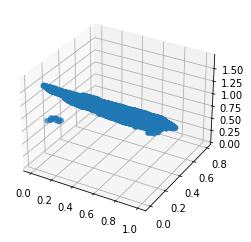

In [53]:
ax = plt.axes(projection='3d')
ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2])
ax.scatter(xyz[0,0], xyz[0,1], xyz[0,2], color='red')

In [54]:
plane = pyransac3d.Plane()
best_eq, best_inliers = plane.fit(xyz, 0.01)
a,b,c,d = best_eq
print(f'Equation of plane: {a} x + {b} y + {c} z + {d} = 0')

Equation of plane: -0.03134583988881132 x + 0.9104698542967173 y + 0.41238584206854045 z + -0.7066375983369544 = 0


In [55]:
def get_rotation_mat(M):
    # https://stackoverflow.com/questions/9423621/3d-rotations-of-a-plane
    N = (0,0,1)
    c = np.dot(M,N) 
    x,y,z = np.cross(M,N) / np.linalg.norm(np.cross(M,N))
    s = np.sqrt(1 - c*c)
    C = 1 - c
    rmat = np.array([[ x*x*C+c,    x*y*C-z*s,  x*z*C+y*s ],
                    [ y*x*C+z*s,  y*y*C+c,    y*z*C-x*s ],
                    [ z*x*C-y*s,  z*y*C+x*s,  z*z*C+c   ]])
    return rmat


Equation of plane: -0.003788144770112921 x + 0.007079860062482801 y + 0.9999677622507118 z + -0.6983496735555994 = 0


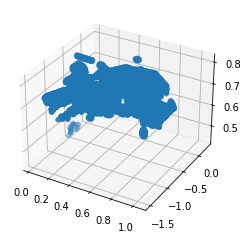

In [56]:
rmat = get_rotation_mat([a,b,c])
xyz_rotated = np.dot(xyz, rmat.T)
assert(xyz.shape==xyz_rotated.shape)
ax = plt.axes(projection='3d')
ax.scatter(xyz_rotated[:,0], xyz_rotated[:,1], xyz_rotated[:,2])
[a,b,c,d], best_inliers = plane.fit(xyz_rotated, 0.01)
print(f'Equation of plane: {a} x + {b} y + {c} z + {d} = 0')

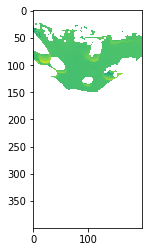

In [57]:
height_map_rotated = xyz_rotated[:,2].reshape((height_map.shape))
plt.imshow(height_map_rotated)
plt.show()